In [1]:
import os
import shutil
import random
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torchvision import  transforms
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image

In [2]:
best_model=YOLO('runs/classify/train2/weights/best.pt')

In [3]:
def classify_clothtags(image_path):
  results=best_model(image_path)
  probs=results[0].probs
  predicted_class=results[0].names[probs.top1]
  confidence=probs.top1conf.item()

  img=Image.open(image_path)
  plt.figure(figsize=(6,6))
  plt.imshow(img)
  plt.title(f'Prediction : {predicted_class}\nConfidence :{confidence:.2f}')
  plt.axis('off')
  plt.show()

  return{
      'predictions':predicted_class,
      'confidence':confidence,
      'all_probobilities':{
          'good':probs.data[0].item(),
          'defects':probs.data[0].item()

      }
  }


image 1/1 C:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\test\defects\PXL_20251008_151907341.MP.jpg: 224x224 defects 1.00, good 0.00, 10.9ms
Speed: 49.0ms preprocess, 10.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


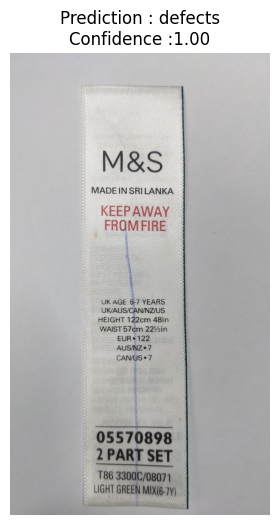

{'predictions': 'defects',
 'confidence': 0.9999687671661377,
 'all_probobilities': {'good': 0.9999687671661377,
  'defects': 0.9999687671661377}}

In [4]:
classify_clothtags('C:/Users/MSI/Documents/GitHub/ClothTagNet/fabric_classification/test/defects/PXL_20251008_151907341.MP.jpg')

In [7]:
results=best_model('C:/Users/MSI/Documents/GitHub/ClothTagNet/fabric_classification/test/defects/PXL_20251008_151907341.MP.jpg')
probs=results[0].probs
predicted_class=results[0].names[probs.top1]
print(predicted_class)


image 1/1 C:\Users\MSI\Documents\GitHub\ClothTagNet\fabric_classification\test\defects\PXL_20251008_151907341.MP.jpg: 224x224 defects 1.00, good 0.00, 7.8ms
Speed: 37.9ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
defects
